建立一個與論文相似的GA-CNN架構網路

首先將需要的套件導入。

In [255]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np


定義需要的超參數

In [256]:
KERNEL_SIZES = (3,3)
FILTER_NUMDERS = (32,64)
POOLING_SIZES = ((2,2),(2,2))
STAGES_NEURONS = (3,4)
STAGE_NUM = 2
INPUT_SIZE = (32,32,3)
OUTPUT_NUM = 10


optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
epoch = 3
batch_size = 128
generation = 10
pm = 0.1
pc = 0.6
qm = 0.5
qc = 0.05
population = 4

定義幾個類別包裝必要的參數與函式。

In [257]:

class GA_CNN_neuron():
    def __init__(self, filter,  kernel):
        self.input_neurons = []
        self.output_neurons = []
        self.input = None
        self.output = None
        self.Conv_layer = Conv2D(filter, kernel,padding='same')

class GA_CNN_stage():
    def __init__(self, input_size, input = None):
        self.hidden_neurons = []
        self.input_neuron = None
        self.output_neuron = None
        self.n_num = 0
        if (input != None):
            self.input = input
        else:
            self.input = layers.Input(input_size)

    def create_hidden_structure(self, neuron_num, filter, kernel):
        self.input_neuron = Conv2D(filter, kernel,padding='same')
        for i in range(neuron_num):
            self.hidden_neurons.append(GA_CNN_neuron(filter, kernel))
        self.n_num = neuron_num

    def link_connection(self, encoded_bits):
        code_list = encoded_bits.split('-')
        if (len(code_list) != self.n_num-1):
            print("Error: Incorresponding size of encoded bits to neuron number")
            print(code_list)
            return 
        for bits_index in range(self.n_num-1):
            bit_num = 0
            for bit in code_list[bits_index]:
                if (int(bit) == 1):
                    self.hidden_neurons[bits_index+1].input_neurons.append(bit_num)
                    self.hidden_neurons[bit_num].output_neurons.append(bits_index+1)
                bit_num += 1
        for neuron in self.hidden_neurons:
            if (neuron.input_neurons == []):
                neuron.input_neurons.append(-1)
            if (neuron.output_neurons == []):
                neuron.output_neurons.append(self.n_num)
        for n in self.hidden_neurons:
            input = []
            for i in n.input_neurons:
                if (i == -1):
                    n.input = self.input_neuron(self.input)
                    break
                else:
                    if (type(input) == list):
                        input = self.hidden_neurons[i].output
                    else:
                        input = layers.Concatenate()([input,self.hidden_neurons[i].output])
                n.input = input
            n.output = n.Conv_layer(n.input)

    def end_connection(self, filter,kernel, pooling):
        output = []
        for n in self.hidden_neurons:
            if (n.output_neurons[-1] == self.n_num):
                if (type(output) == list):
                    output = n.output
                else:
                    output = layers.Concatenate()([output,n.output])
        pool = layers.Conv2D(filter, kernel,padding='same')(output)
        self.output_neuron = layers.MaxPool2D(pooling)(pool)


class GA_CNN():
    def __init__(self):
        self.model = None
    def create_network(self, stages_number, stages_neuron_num, genes, poolings_size, filters_num, kernels_size, _input_size):
        model_stages = []
        for i in  range(stages_number):
            if (i == 0):
                current_stage = GA_CNN_stage(_input_size)
                current_stage.create_hidden_structure(stages_neuron_num[i], filters_num[i], kernels_size[i])
            else:
                current_stage = GA_CNN_stage(model_stages[i-1].output_neuron.shape[1:],model_stages[i-1].output_neuron)
                current_stage.create_hidden_structure(stages_neuron_num[i], filters_num[i], kernels_size[i])
            current_stage.link_connection(genes[i])
            current_stage.end_connection(filters_num[i], kernels_size[i],poolings_size[i])
            model_stages.append(current_stage)
        flatten = layers.Flatten()(model_stages[-1].output_neuron)
        output = layers.Dense(OUTPUT_NUM,'softmax')(flatten)
        return Model(model_stages[0].input, output)



測試我們的類別是否運作如預期。

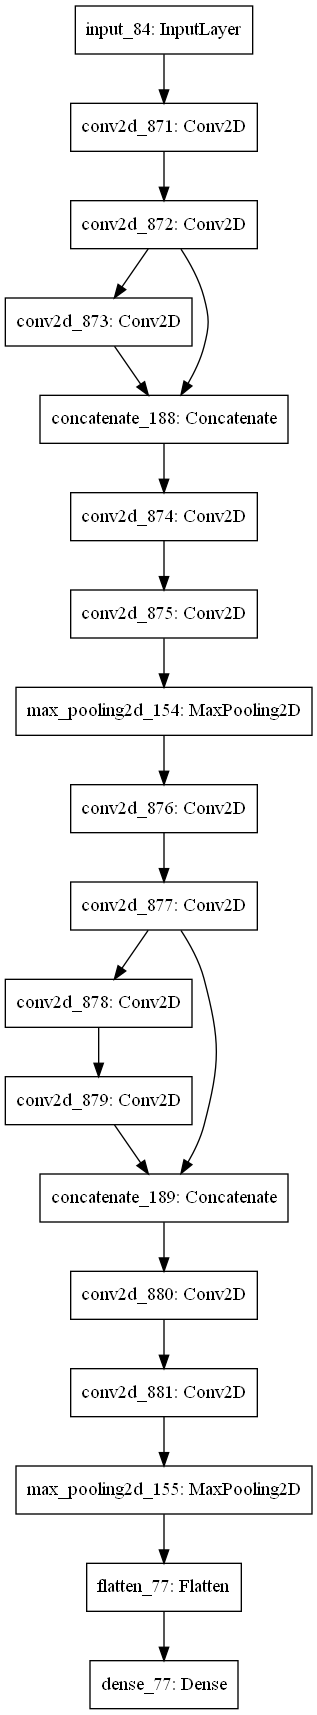

In [258]:
GA_MODEL = GA_CNN()
plot_model(GA_MODEL.create_network(2,[3,4],['1-11','1-01-101'],[(2,2),(2,2)],[32,64],[3,3],(32,32,3)))


加入GA的部分，論文中使用的是二進制的加密，在crossover的部分基礎單元為一個stage。在此先定義我們的一個完整基因序應該如何表達stages之間的分別，論文中，一個stage內會以"-"分隔來代表單一神經元的連結情況，而不同的stage之間並無特別提及，我們以"/"來做分隔。我們的實驗以兩個stage進行，所以範例的基因片段為"0-00-000/0-00-000-000"。

輪盤的部分與課堂的並無差異，均以分數作為評判選擇母代。

In [259]:
def roulette_selection(pop: list, scores: list, n: int):
    # compute the sum of fitness
    fitness_total = float(sum(scores))
    # compute probability of fitness
    fitness_prob = [f / fitness_total for f in scores]
    # compute cumulative probability of fitness
    fitness_cum_prob = [sum(fitness_prob[: i + 1]) for i in range(len(fitness_prob))]
    # list of selected parents
    pop_selected = []
    for _ in range(n):
        r = np.random.uniform()
        for i, p in enumerate(pop):
            if r <= fitness_cum_prob[i]:
                pop_selected.append(p)
                break
    return pop_selected

In [260]:
p1 = "1-01/1-01-111/1-11-111-1111"
p2 = "0-10/0-10-000/1-11-111-0000"
p3 = "0-11/1-00-111/1-10-101-1111"
scores = [1.0, 0.6, 0.1]
for i in range(10):
    p = roulette_selection([p1,p2,p3], scores,2)
    print(f'loop {i+1}: ',p)

loop 1:  ['1-01/1-01-111/1-11-111-1111', '1-01/1-01-111/1-11-111-1111']
loop 2:  ['0-10/0-10-000/1-11-111-0000', '1-01/1-01-111/1-11-111-1111']
loop 3:  ['1-01/1-01-111/1-11-111-1111', '0-10/0-10-000/1-11-111-0000']
loop 4:  ['0-10/0-10-000/1-11-111-0000', '1-01/1-01-111/1-11-111-1111']
loop 5:  ['1-01/1-01-111/1-11-111-1111', '1-01/1-01-111/1-11-111-1111']
loop 6:  ['0-10/0-10-000/1-11-111-0000', '0-10/0-10-000/1-11-111-0000']
loop 7:  ['1-01/1-01-111/1-11-111-1111', '1-01/1-01-111/1-11-111-1111']
loop 8:  ['0-10/0-10-000/1-11-111-0000', '1-01/1-01-111/1-11-111-1111']
loop 9:  ['0-10/0-10-000/1-11-111-0000', '1-01/1-01-111/1-11-111-1111']
loop 10:  ['0-11/1-00-111/1-10-101-1111', '1-01/1-01-111/1-11-111-1111']


crossover的部分需要對基因以"/"分割，而我們的基因為兩段stage，所以交配會影響的只有stage的搭配，內部的結構只會由突變改變。

In [261]:
def crossover(p1: str, p2: str, pc: float):
    # children are copies of parents by default
    print("Parent: ",p1, p2)
    s1, s2 = p1.split('/'), p2.split('/')
    c1, c2 = p1, p2
    # check for recombination
    if np.random.rand() < pc:
        # select crossover point that is not on the end of the string
        pt = np.random.randint(1,len(s1))
        # perform crossover
        c1 = s1[:1] + s2[1:]
        c2 = s2[:1] + s1[1:]
        print("Children: ", "/".join(c1), "/".join(c2))
        return "/".join(c1), "/".join(c2)
    else:
        return c1, c2

In [262]:
p1 = '1-00/1-00-110' 
p2 = "1-01/0-10-010"

c1,c2 = crossover(p1, p2, 1)
print(p1,p2)
print(c1, c2)

Parent:  1-00/1-00-110 1-01/0-10-010
Children:  1-00/0-10-010 1-01/1-00-110
1-00/1-00-110 1-01/0-10-010
1-00/0-10-010 1-01/1-00-110


In [263]:
p1 = "1-01/1-01-111/1-11-111-1111"
p2 = "0-10/0-10-000/1-11-111-0000"
c1,c2 = crossover(p1, p2, 1)
print(p1,p2)
print(c1, c2)

Parent:  1-01/1-01-111/1-11-111-1111 0-10/0-10-000/1-11-111-0000
Children:  1-01/0-10-000/1-11-111-0000 0-10/1-01-111/1-11-111-1111
1-01/1-01-111/1-11-111-1111 0-10/0-10-000/1-11-111-0000
1-01/0-10-000/1-11-111-0000 0-10/1-01-111/1-11-111-1111


突變的程式應該與課堂講義相同，僅需改動我們分割基因序的方式即可。

In [264]:
def mutation(x: str, pm: float):
    print("Before M: ", x)
    s = x.split('/')
    stages = s
    for s_i in range(len(s)):
        stages[s_i] = s[s_i].split('-')
    for i in range(len(stages)):
        for j in range(len(stages[i])):
            for k in range(len(stages[i][j])):
                if np.random.rand() < pm:
                    stages[i][j] = stages[i][j][:k] + str(1 - int(stages[i][j][k])) + stages[i][j][k+1:]
        stages[i] = "-".join(stages[i])
    print("After M: ", "/".join(stages))
    return "/".join(stages)


In [265]:
x = '1-10-101/1-11-100-1000'
for index in range(10):
    print(f"loop {index}: [origin: {x}, changed: {mutation(x,0.1)}]")

Before M:  1-10-101/1-11-100-1000
After M:  1-00-101/1-11-100-1010
loop 0: [origin: 1-10-101/1-11-100-1000, changed: 1-00-101/1-11-100-1010]
Before M:  1-10-101/1-11-100-1000
After M:  1-10-101/1-11-100-0010
loop 1: [origin: 1-10-101/1-11-100-1000, changed: 1-10-101/1-11-100-0010]
Before M:  1-10-101/1-11-100-1000
After M:  1-11-101/0-11-101-1000
loop 2: [origin: 1-10-101/1-11-100-1000, changed: 1-11-101/0-11-101-1000]
Before M:  1-10-101/1-11-100-1000
After M:  0-10-101/0-11-100-1001
loop 3: [origin: 1-10-101/1-11-100-1000, changed: 0-10-101/0-11-100-1001]
Before M:  1-10-101/1-11-100-1000
After M:  1-11-000/1-10-100-1010
loop 4: [origin: 1-10-101/1-11-100-1000, changed: 1-11-000/1-10-100-1010]
Before M:  1-10-101/1-11-100-1000
After M:  1-00-101/1-11-100-1000
loop 5: [origin: 1-10-101/1-11-100-1000, changed: 1-00-101/1-11-100-1000]
Before M:  1-10-101/1-11-100-1000
After M:  1-10-111/1-01-100-1000
loop 6: [origin: 1-10-101/1-11-100-1000, changed: 1-10-111/1-01-100-1000]
Before M:  1-

分數的運算由CNN算出準確率，直接以準確率作為輪盤的面積分布即可。

In [266]:
def fitness(x: str, trainx, trainy, testx, testy):
    genes = x.split('/')
    model = GA_MODEL.create_network(STAGE_NUM,STAGES_NEURONS,genes,POOLING_SIZES,FILTER_NUMDERS,KERNEL_SIZES,INPUT_SIZE)
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    model.summary()
    history = model.fit(trainx, trainy, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(testx,testy))

    return model.evaluate(testx, testy, verbose=0)[1]

隨機產生基因

In [267]:
def random_generate_gene(stages,stage_num):
    temp_gene = ''
    for i in range(stage_num):
        for j in range(1,stages[i]):
            for _ in range(j):
                temp_gene += str(np.random.randint(0,2))
            if (j != stages[i]-1):
                temp_gene += '-'
        if (i != stage_num-1):
            temp_gene += '/'
    return temp_gene

In [268]:
print(random_generate_gene((3,4),2))

0-01/0-10-101


最後將整個系統整合成一個完整的GA函式。

In [269]:
def genetic_algorithm(fitness_func,num_iters, num_pop, pc, pm, trainx, trainy, testx, testy):
    pop_list = []
    for _ in range(num_pop):
        pop_list.append(random_generate_gene(STAGES_NEURONS,STAGE_NUM))
    best, best_eval = pop_list[0], 0
    for it in range(num_iters):
        # evaluate all candidates in the population
        scores = [fitness_func(c,trainx,trainy, testx,testy) for c in pop_list]
        # check for new best solution
        for i in range(num_pop):
            if scores[i] > best_eval:
                best, best_eval = pop_list[i], scores[i]
                print(">%d, new best f(%s) = %.3f" % (it, best, best_eval))
        # select parents
        selected = roulette_selection(pop_list, scores, num_pop)
        print("selected population: ",selected)
        # create the next generation
        children = []
        for i in range(0, num_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i + 1]
            # crossover and mutation
            for c in crossover(p1, p2, pc):
                # mutation
                c = mutation(c, pm)
                # store for next generation
                children.append(c)
        # replace old population with new one that having high scores
        pop_list = children
    return best, best_eval

In [270]:
import tensorflow as tf
from keras.utils import np_utils
(trainx,trainy), (testx,testy) = tf.keras.datasets.cifar10.load_data()
trainx = trainx.astype('float32')/255
testx = testx.astype('float32')/255
trainy = np_utils.to_categorical(trainy)
testy = np_utils.to_categorical(testy)
genetic_algorithm(fitness, generation, population, 0.8, 0.1, trainx,trainy, testx,testy)

Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_882 (Conv2D)             (None, 32, 32, 32)   896         input_85[0][0]                   
                                                                 input_85[0][0]                   
__________________________________________________________________________________________________
conv2d_883 (Conv2D)             (None, 32, 32, 32)   9248        conv2d_882[0][0]                 
__________________________________________________________________________________________________
conv2d_884 (Conv2D)             (None, 32, 32, 32)   9248        conv2d_882[1][0]          

('0-00/0-10-100', 0.673799991607666)